<a href="https://colab.research.google.com/github/PreetiKharb/TensorFlow/blob/master/London_bike_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!pip install gdown
!pip install tesorflow-gpu

ERROR: Could not find a version that satisfies the requirement tesorflow-gpu (from versions: none)
ERROR: No matching distribution found for tesorflow-gpu


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
!gdown --id 1GAD2Hic5XuyvY5iW_NHhV4UkXhIRdlqz --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1GAD2Hic5XuyvY5iW_NHhV4UkXhIRdlqz
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 66.3MB/s]


In [10]:
df = pd.read_csv('london_bike_sharing.csv', parse_dates=['timestamp'], index_col='timestamp')

In [11]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [13]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [14]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


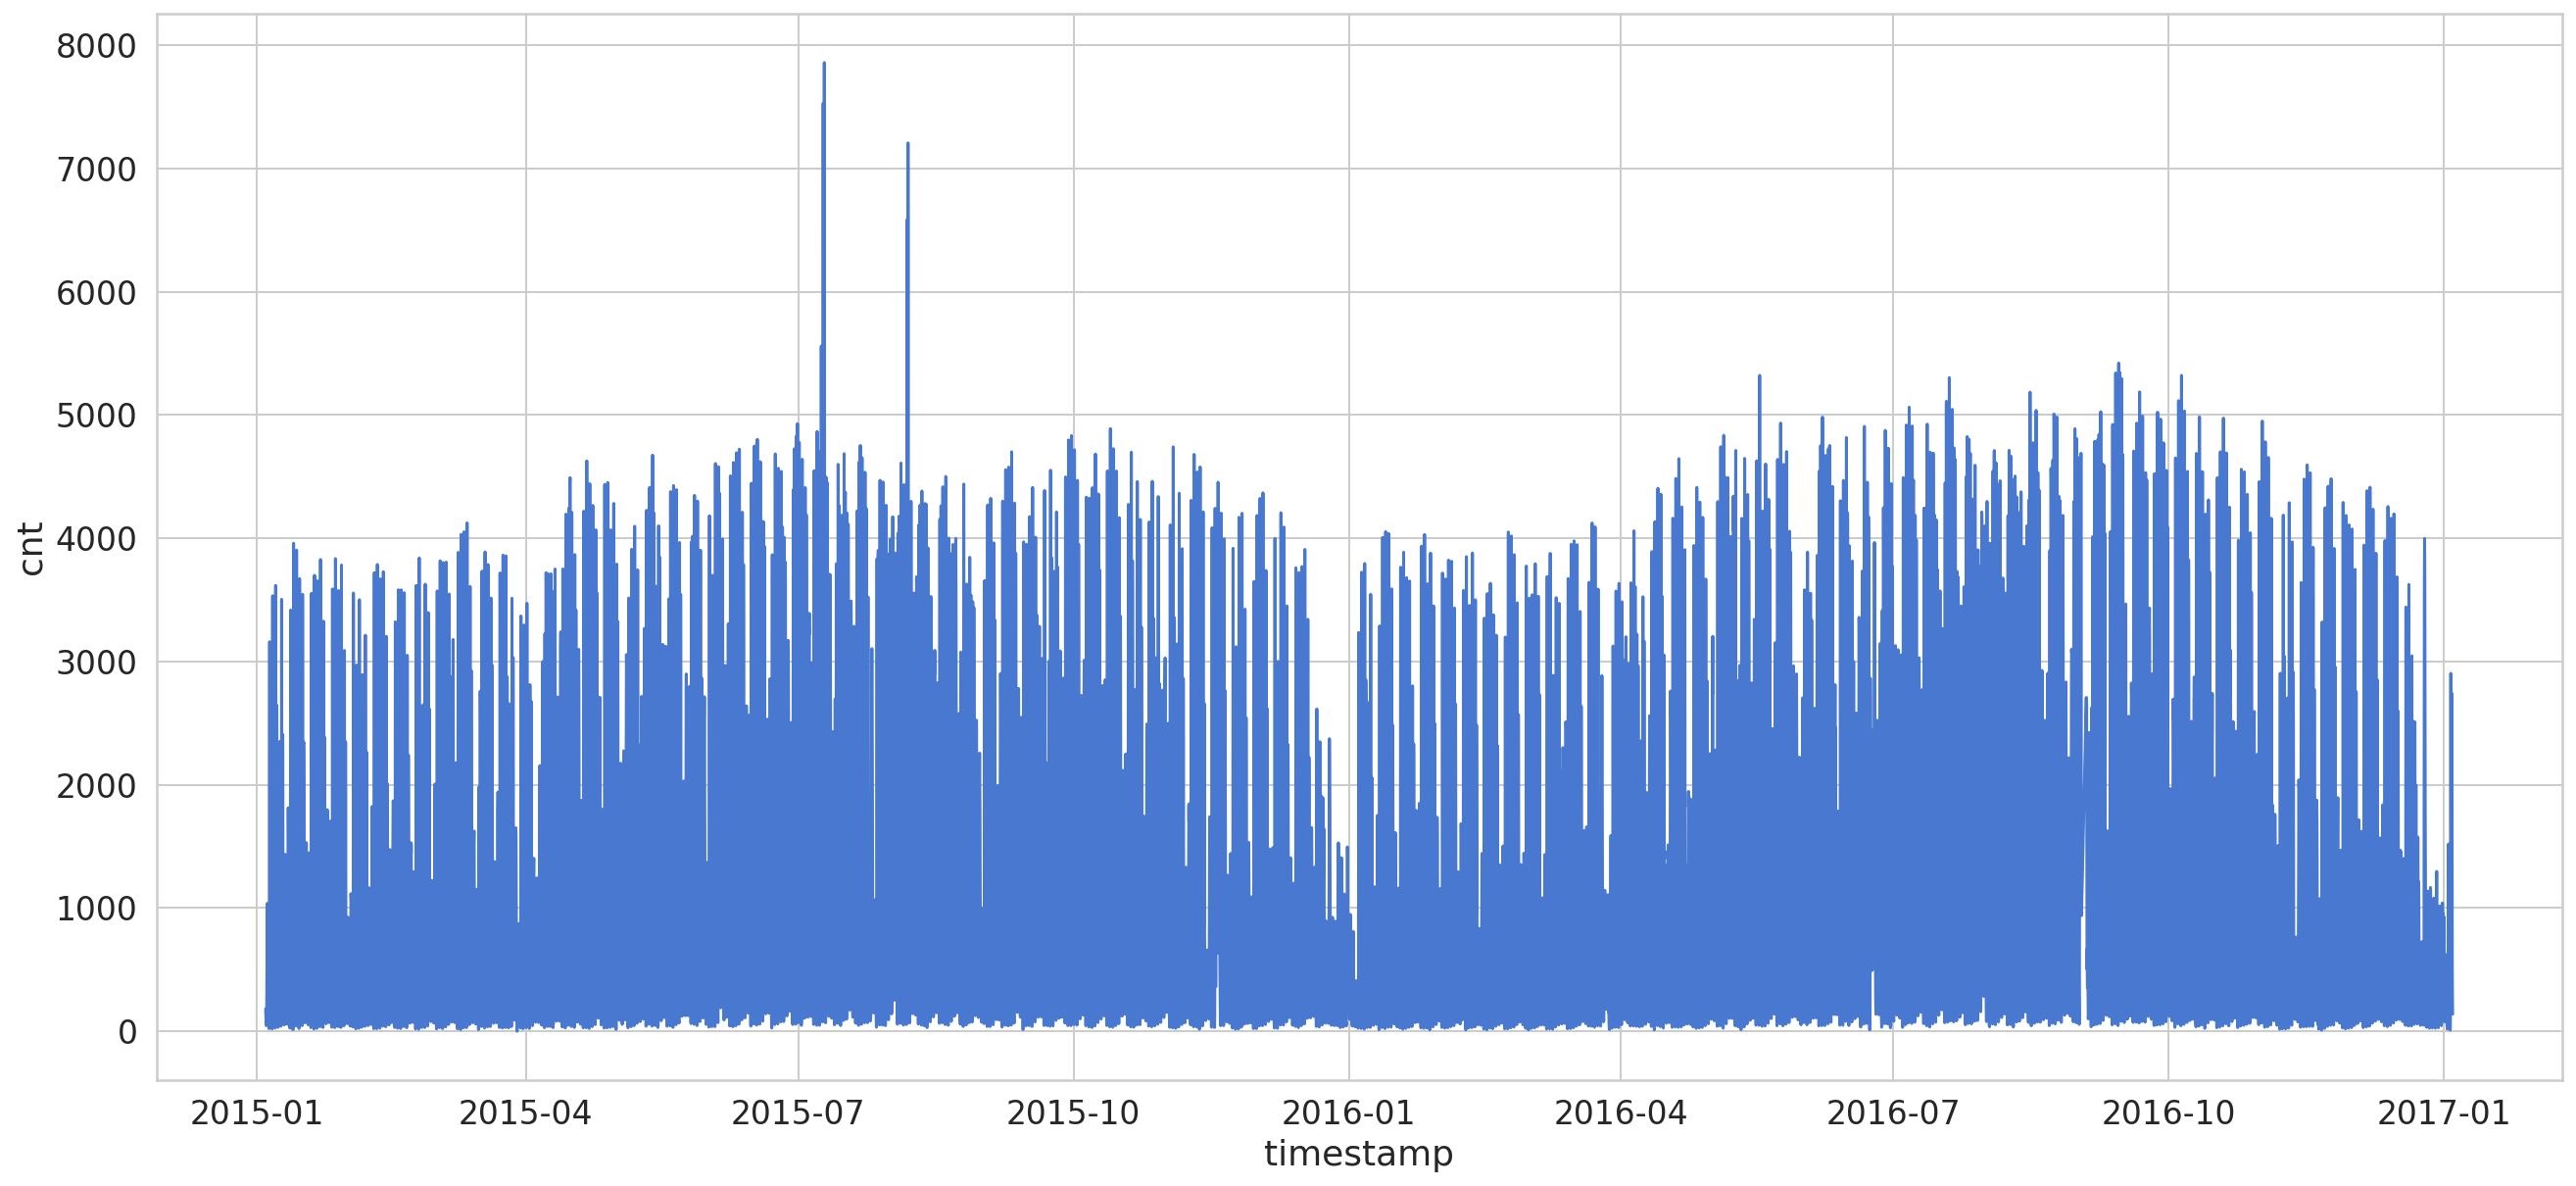

In [15]:
sns.lineplot(x=df.index, y='cnt', data=df)

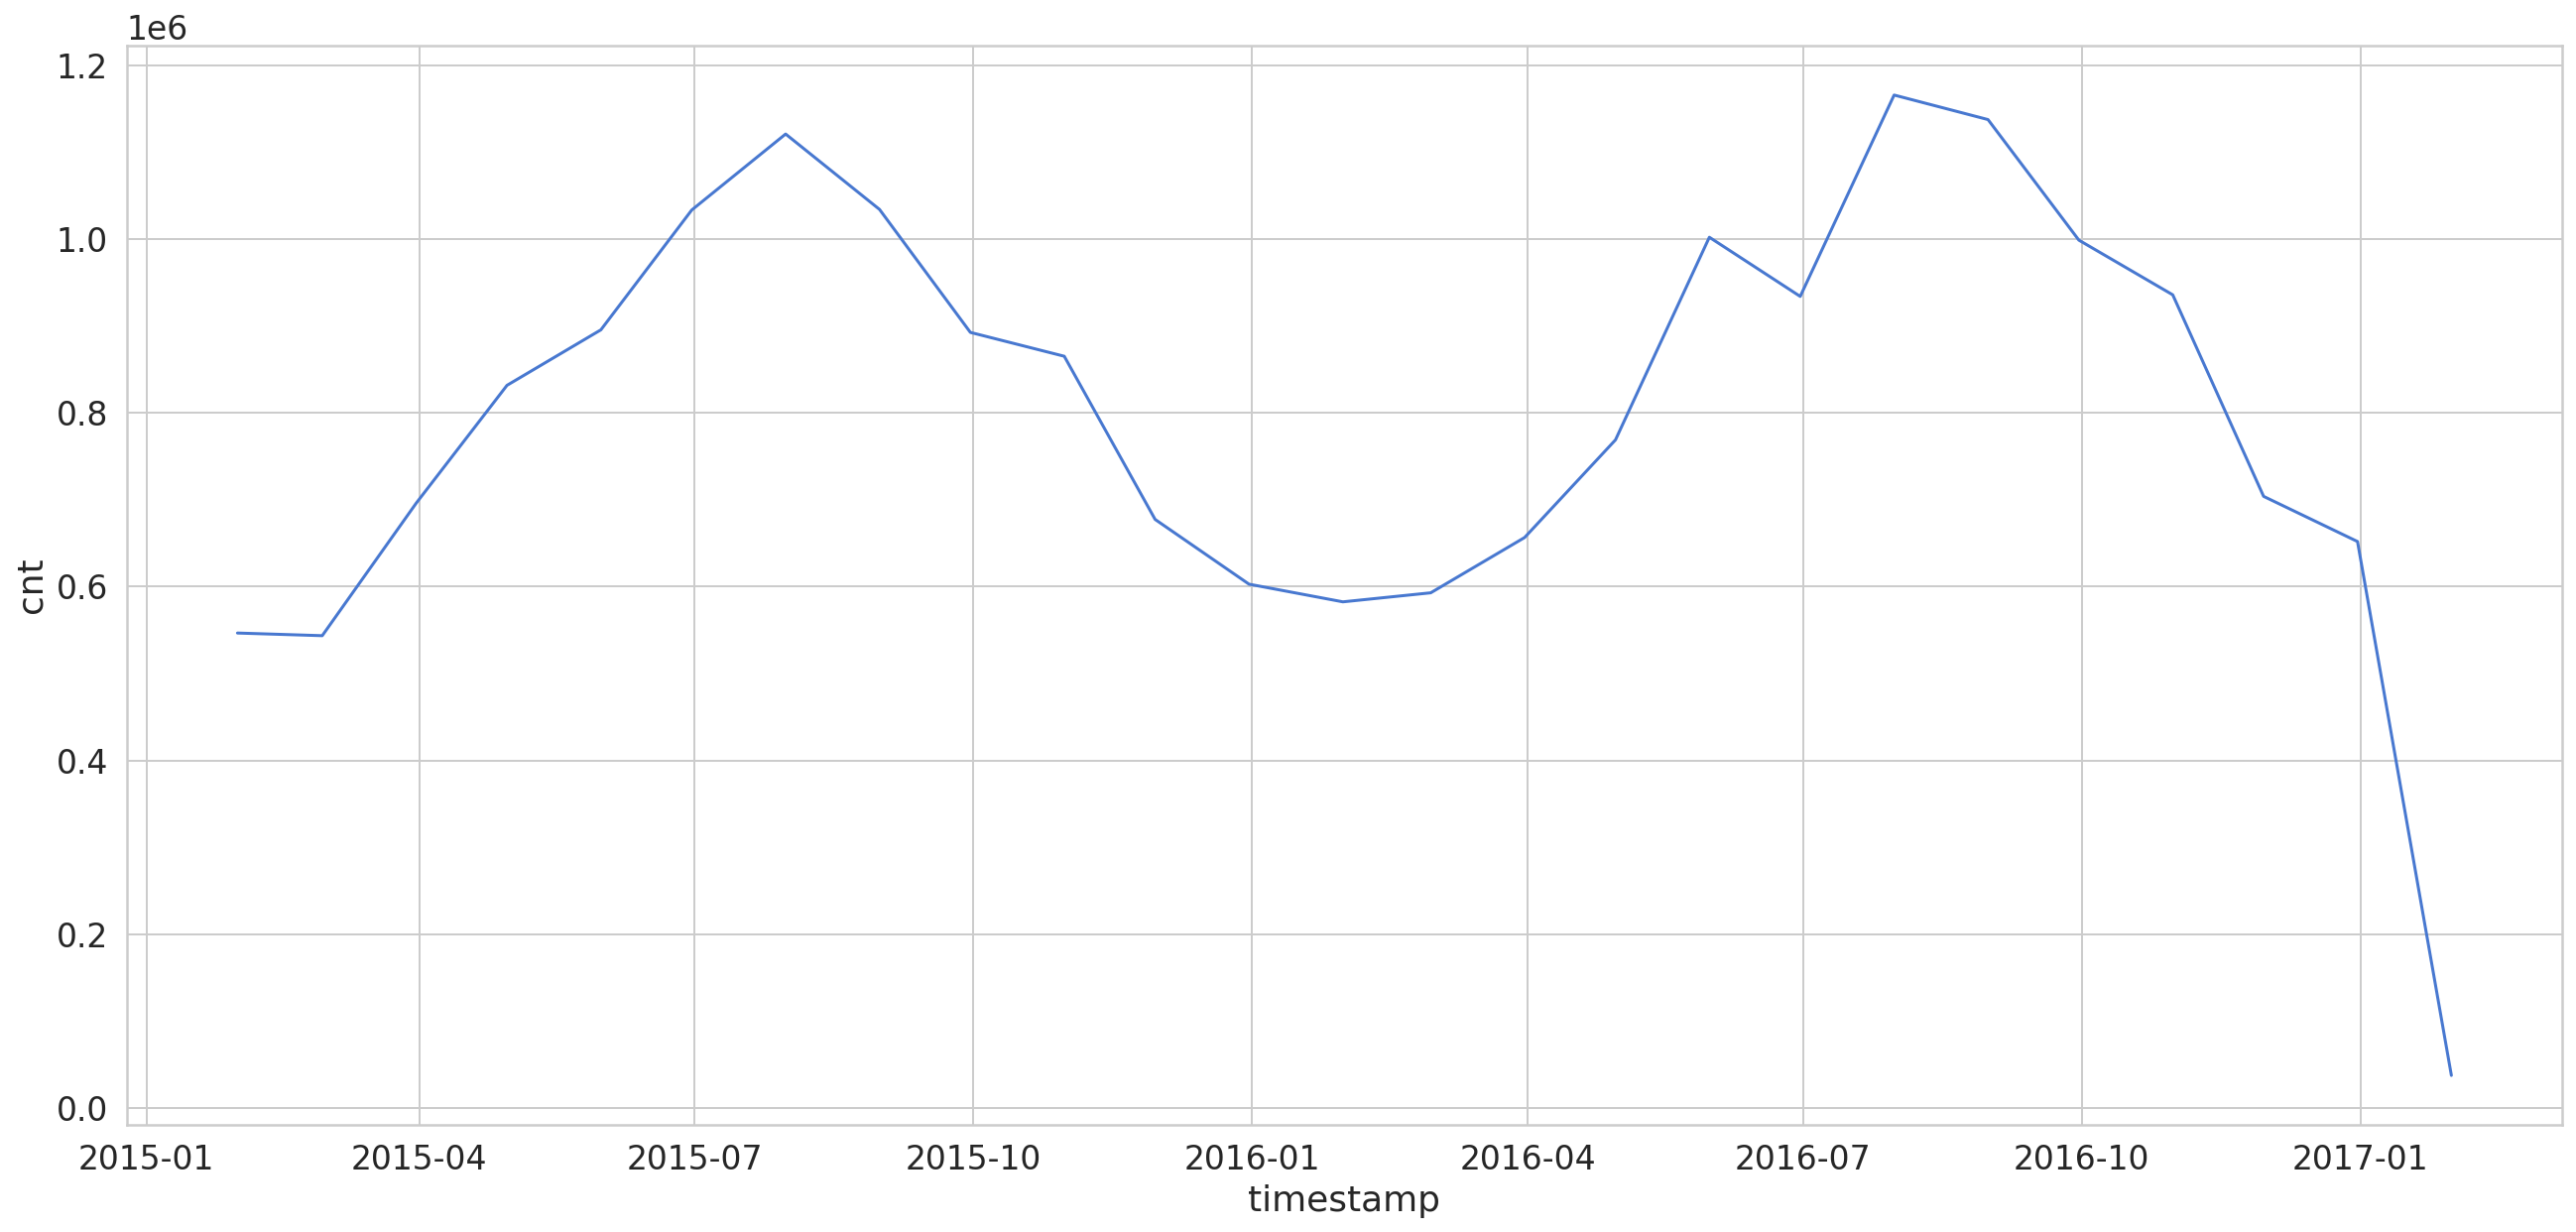

In [16]:
df_by_month = df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month)

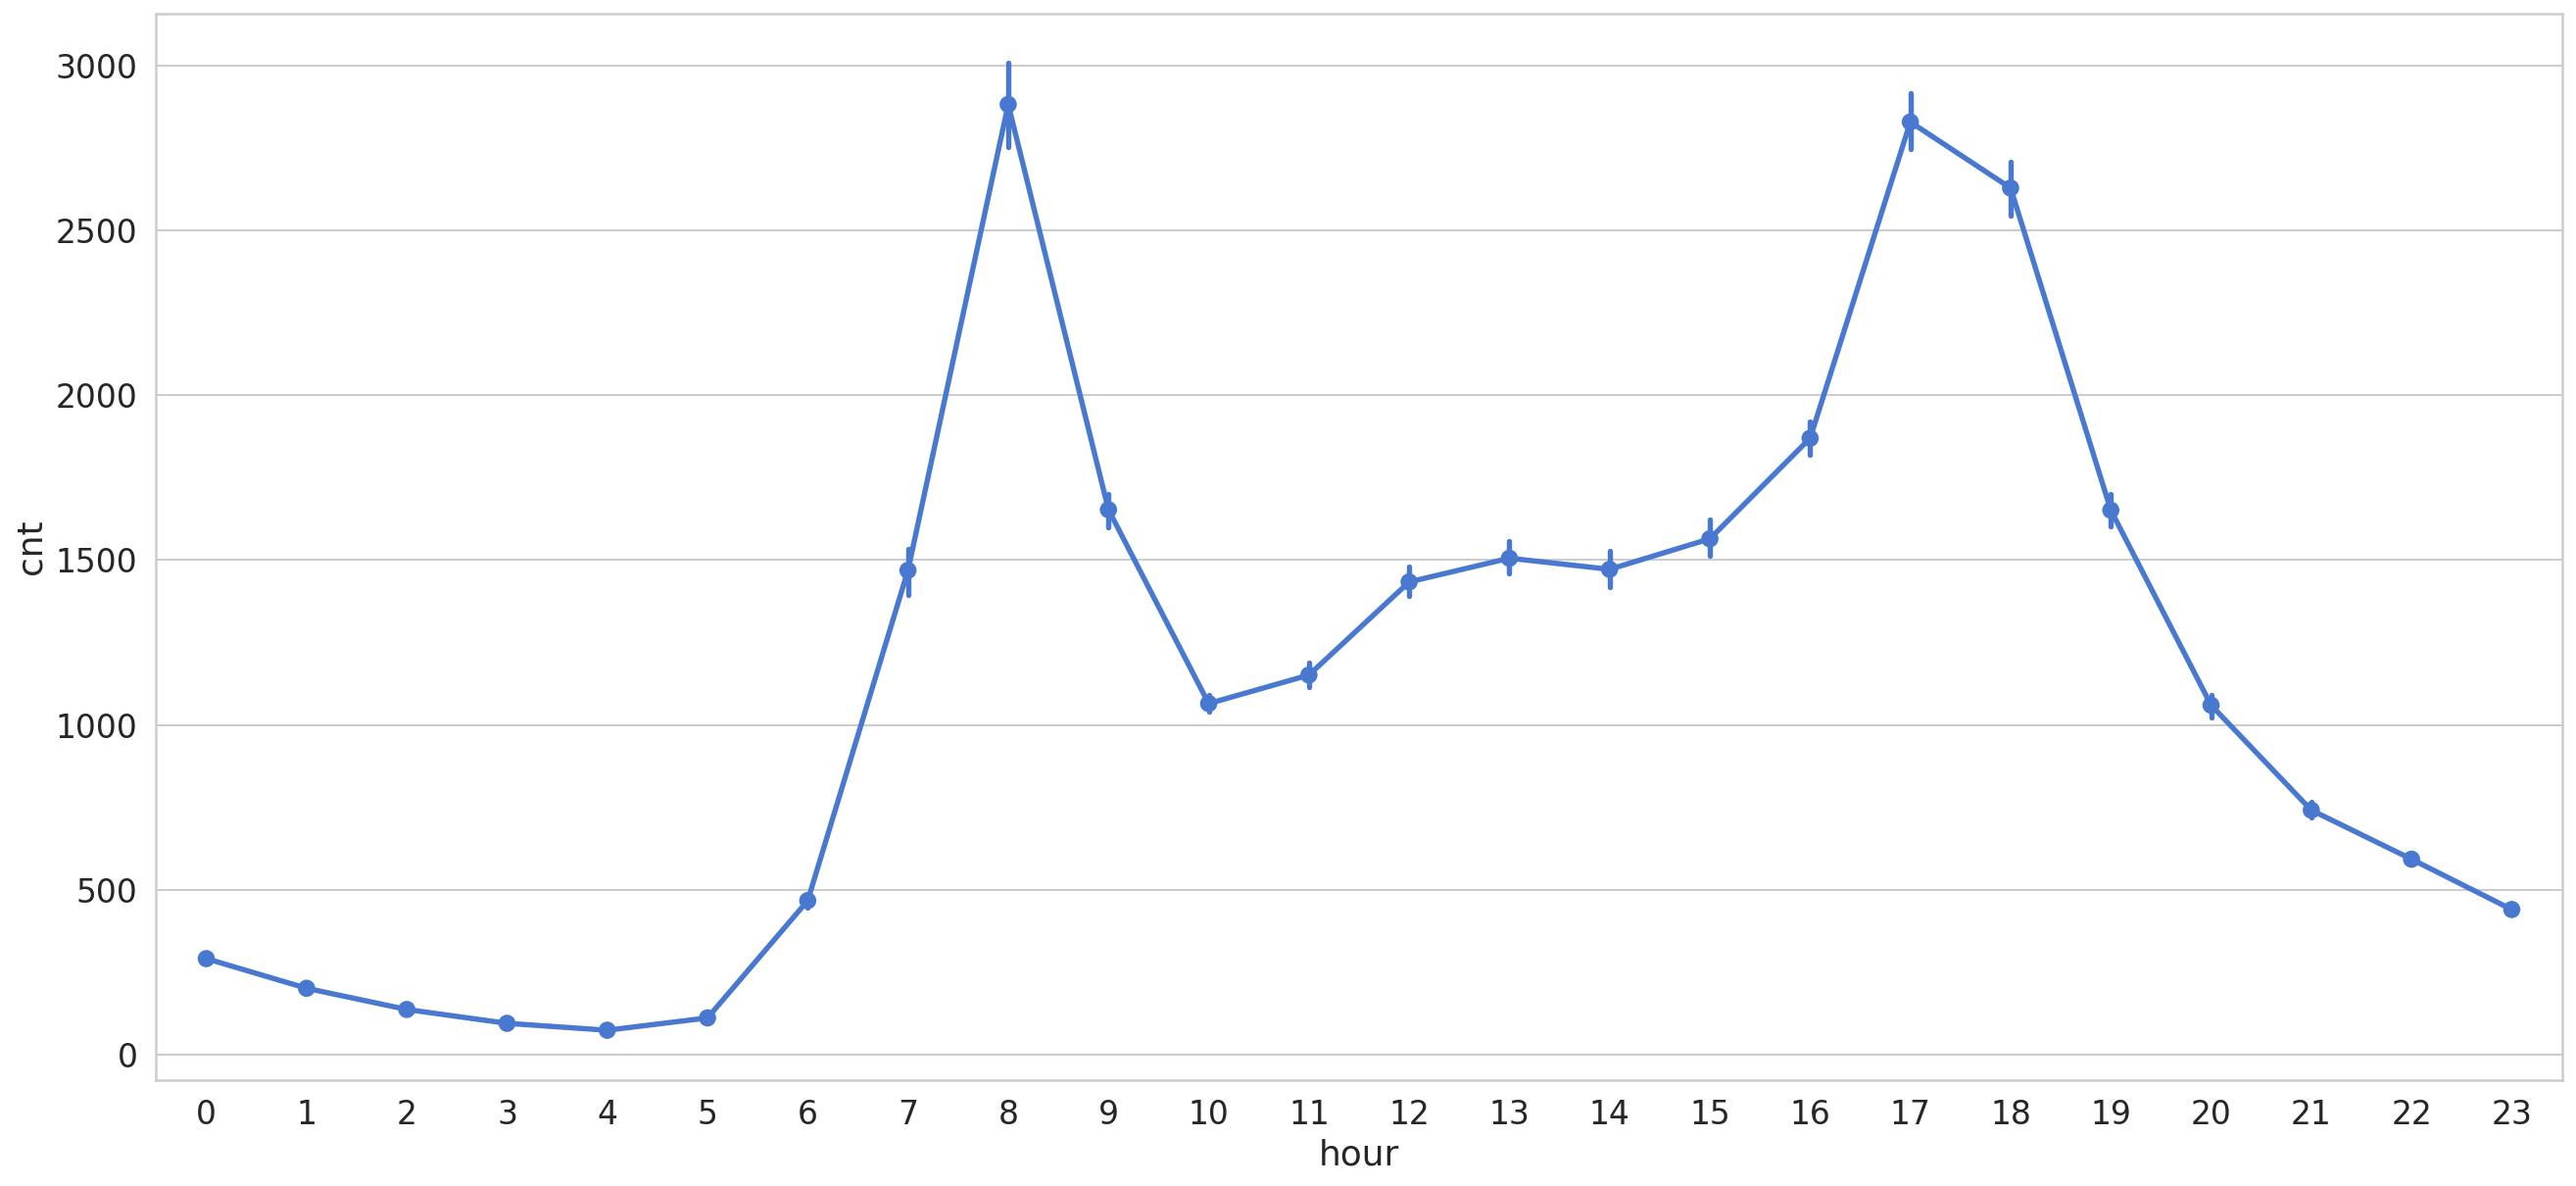

In [17]:
sns.pointplot(data=df, x='hour', y='cnt')

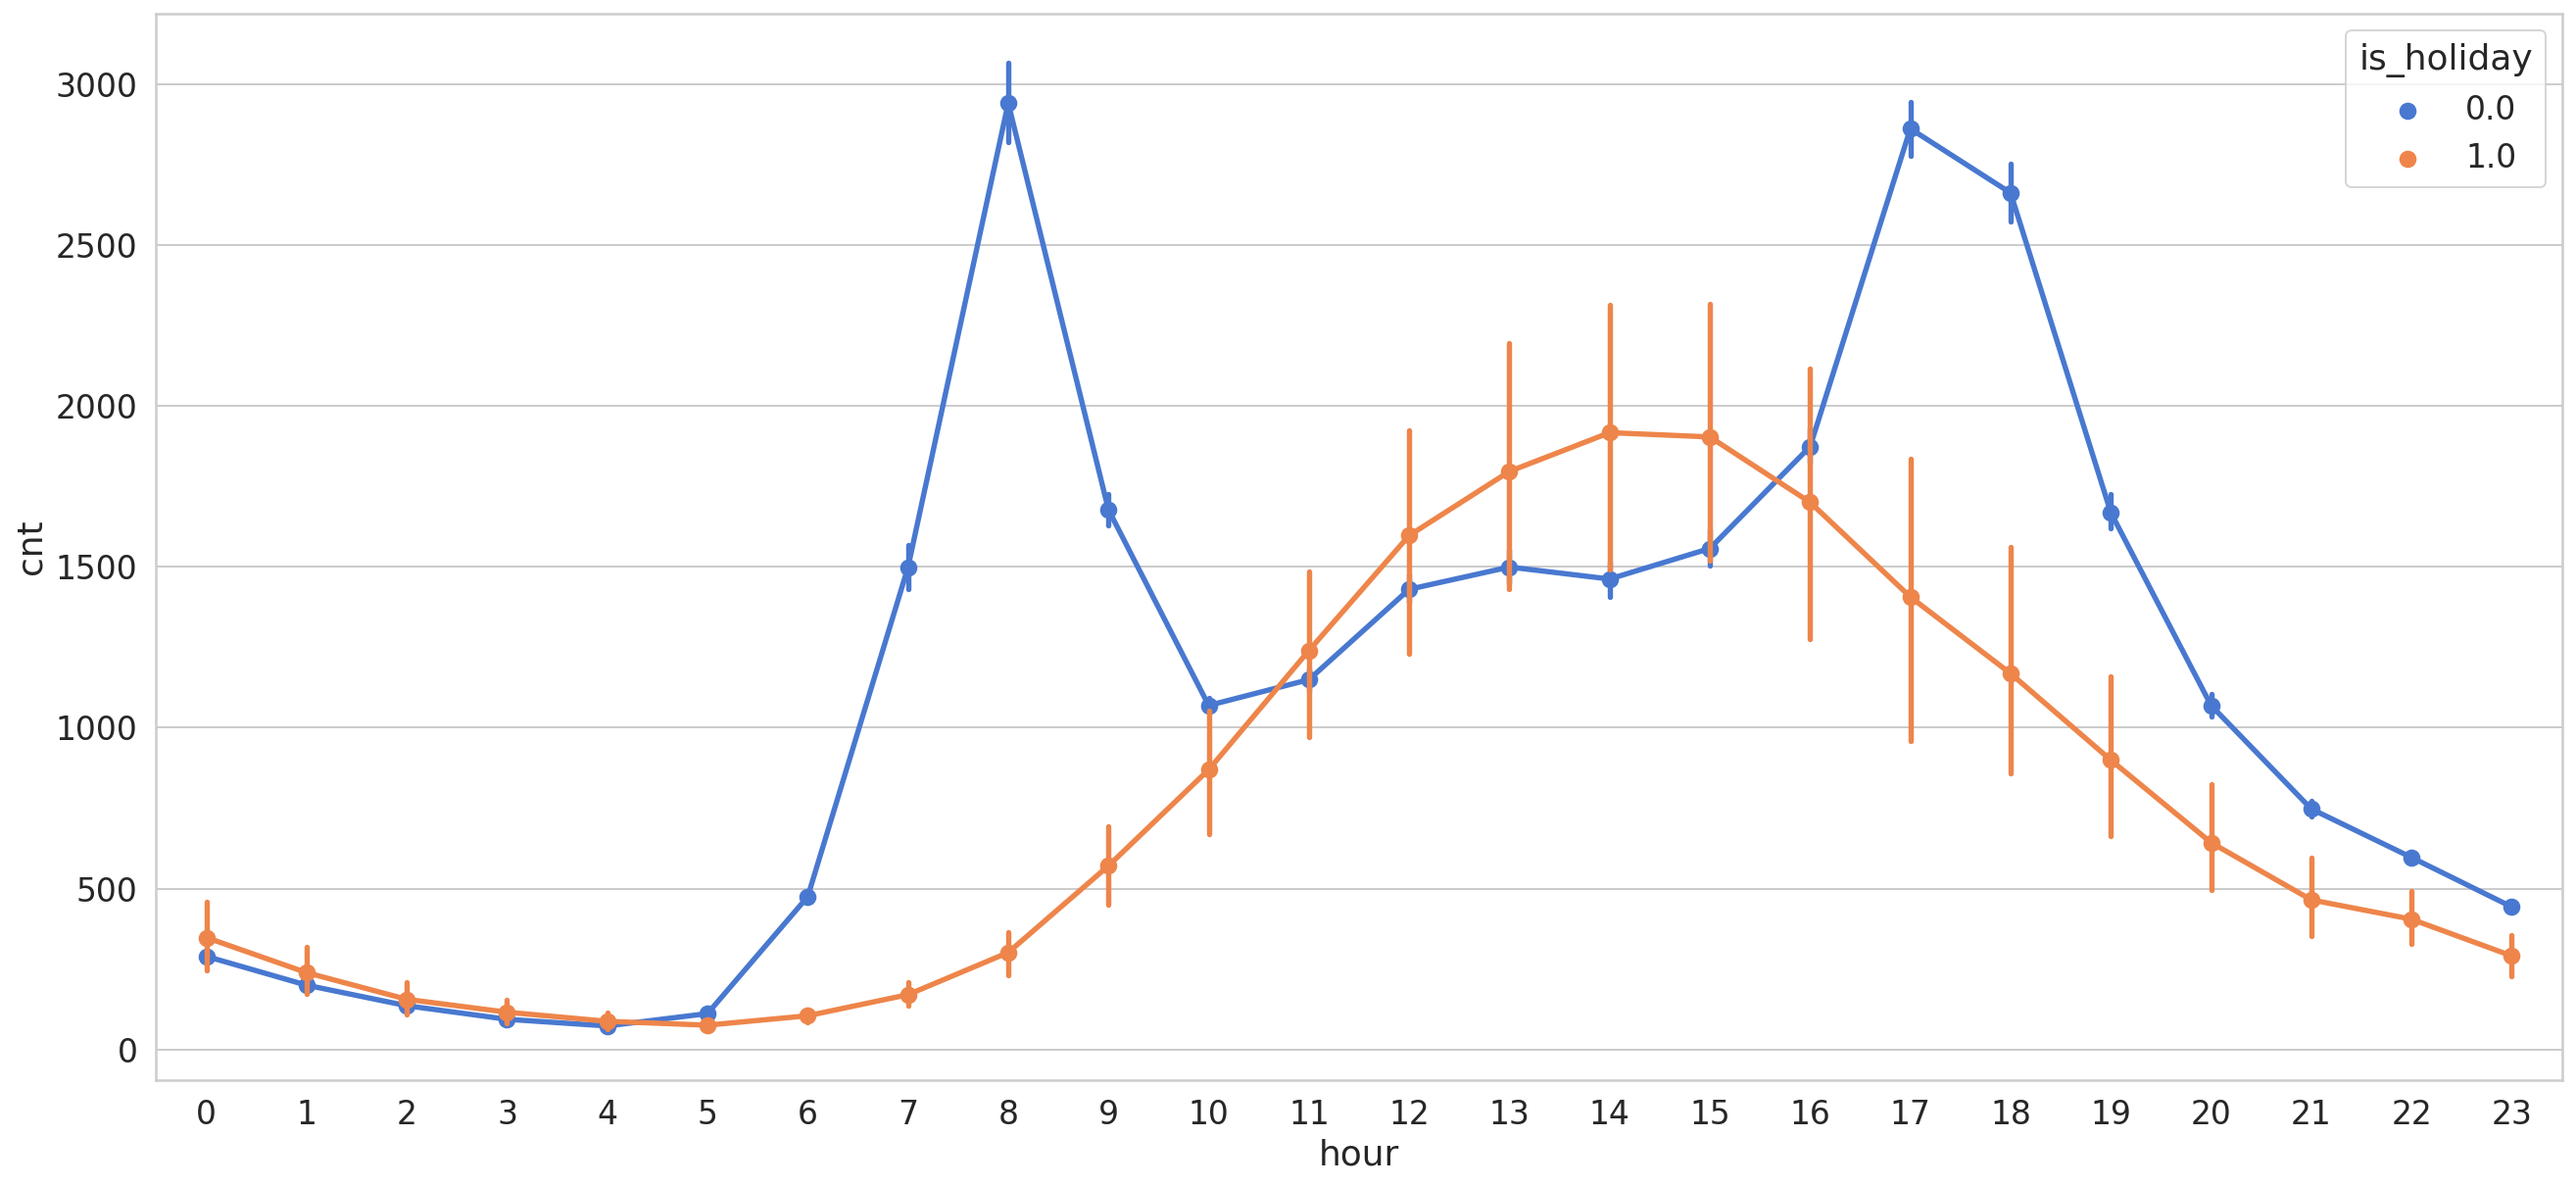

In [18]:
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday')

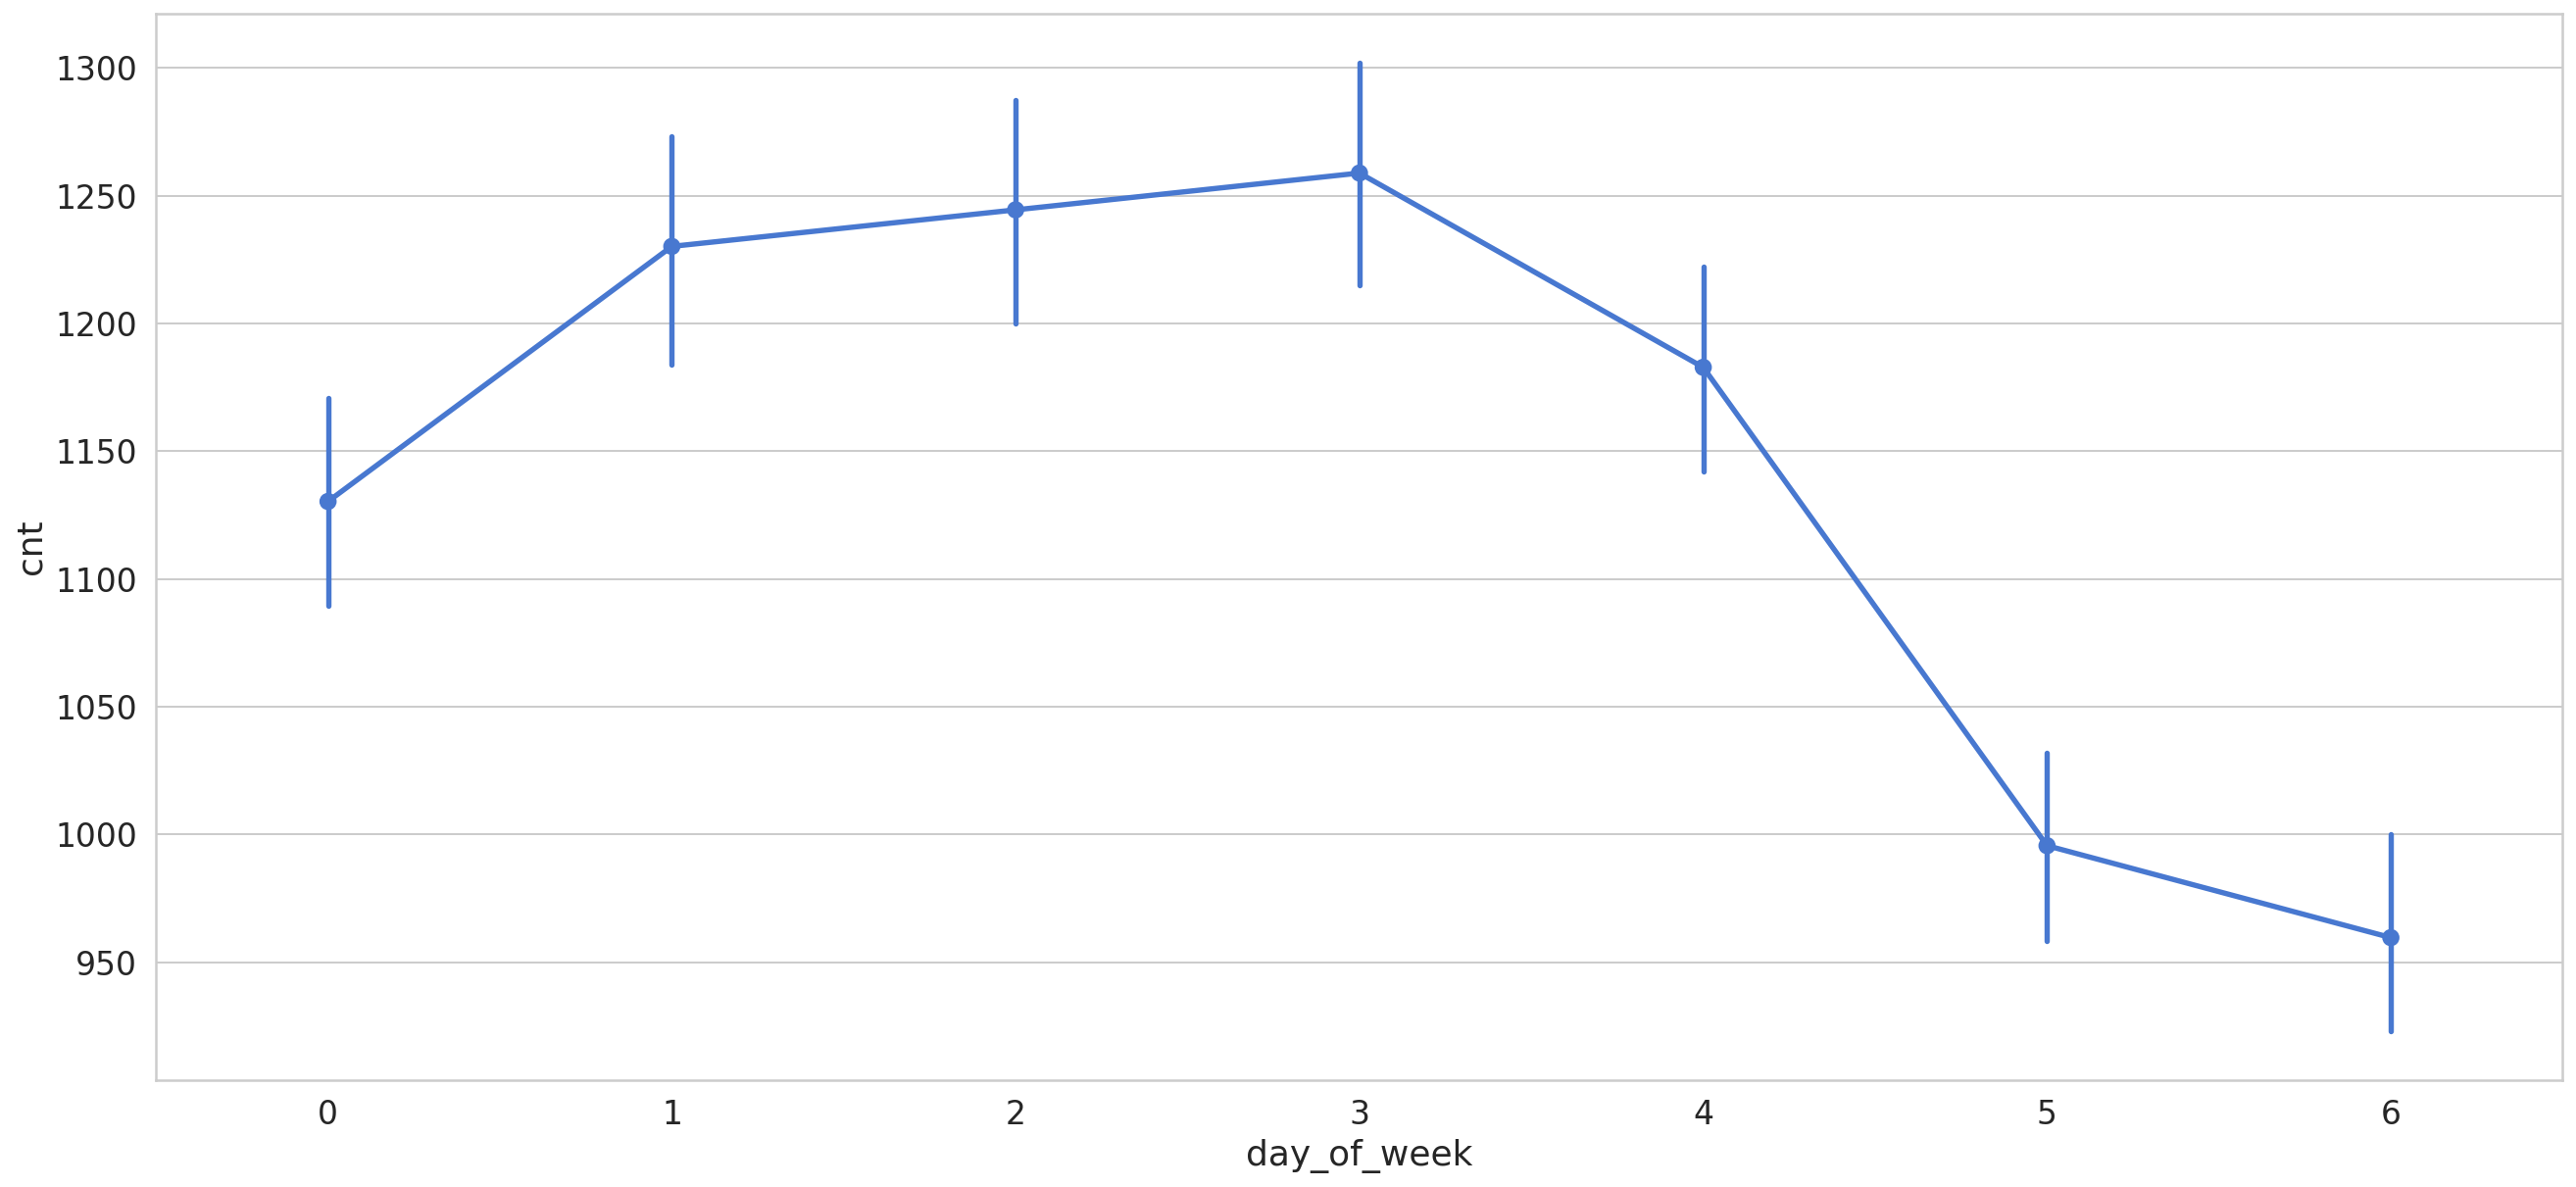

In [19]:
sns.pointplot(data=df, x='day_of_week', y='cnt')

In [20]:
train_size = int(len(df)*0.9)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape)
print(test.shape)


(15672, 13)
(1742, 13)


In [21]:
from sklearn.preprocessing import RobustScaler

f_columns =['t1','t1','hum','wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[: ,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])


test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [22]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [],[]
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [23]:
TIME_STEPS = 24

X_train, y_train = create_dataset(train, train.cnt, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.cnt, time_steps=TIME_STEPS)



In [25]:
#shape [sample, timesteps, features]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15648, 24, 13) (15648,)
(1718, 24, 13) (1718,)


In [26]:
X_test[0][0]

array([-0.37052342, -0.625     ,  7.        ,  0.675     , -0.81818182,
        2.        ,  0.        ,  1.        ,  2.        ,  8.        ,
        6.        , 23.        , 10.        ])

In [27]:
model = keras.Sequential()

model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)

model.add(
    keras.layers.Dropout(
        rate=0.2
    )
)

model.add(
    keras.layers.Dense(
        units=1
    )
)

In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/30
441/441 [==============================] - 38s 9ms/step - loss: 0.3739 - val_loss: 0.1744
Epoch 2/30
441/441 [==============================] - 3s 6ms/step - loss: 0.1272 - val_loss: 0.0909
Epoch 3/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0802 - val_loss: 0.0513
Epoch 4/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0535 - val_loss: 0.0527
Epoch 5/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0448 - val_loss: 0.0405
Epoch 6/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0383 - val_loss: 0.0367
Epoch 7/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0314 - val_loss: 0.0362
Epoch 8/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0271 - val_loss: 0.0283
Epoch 9/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0268 - val_loss: 0.0302
Epoch 10/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0252 - val_loss: 0.034

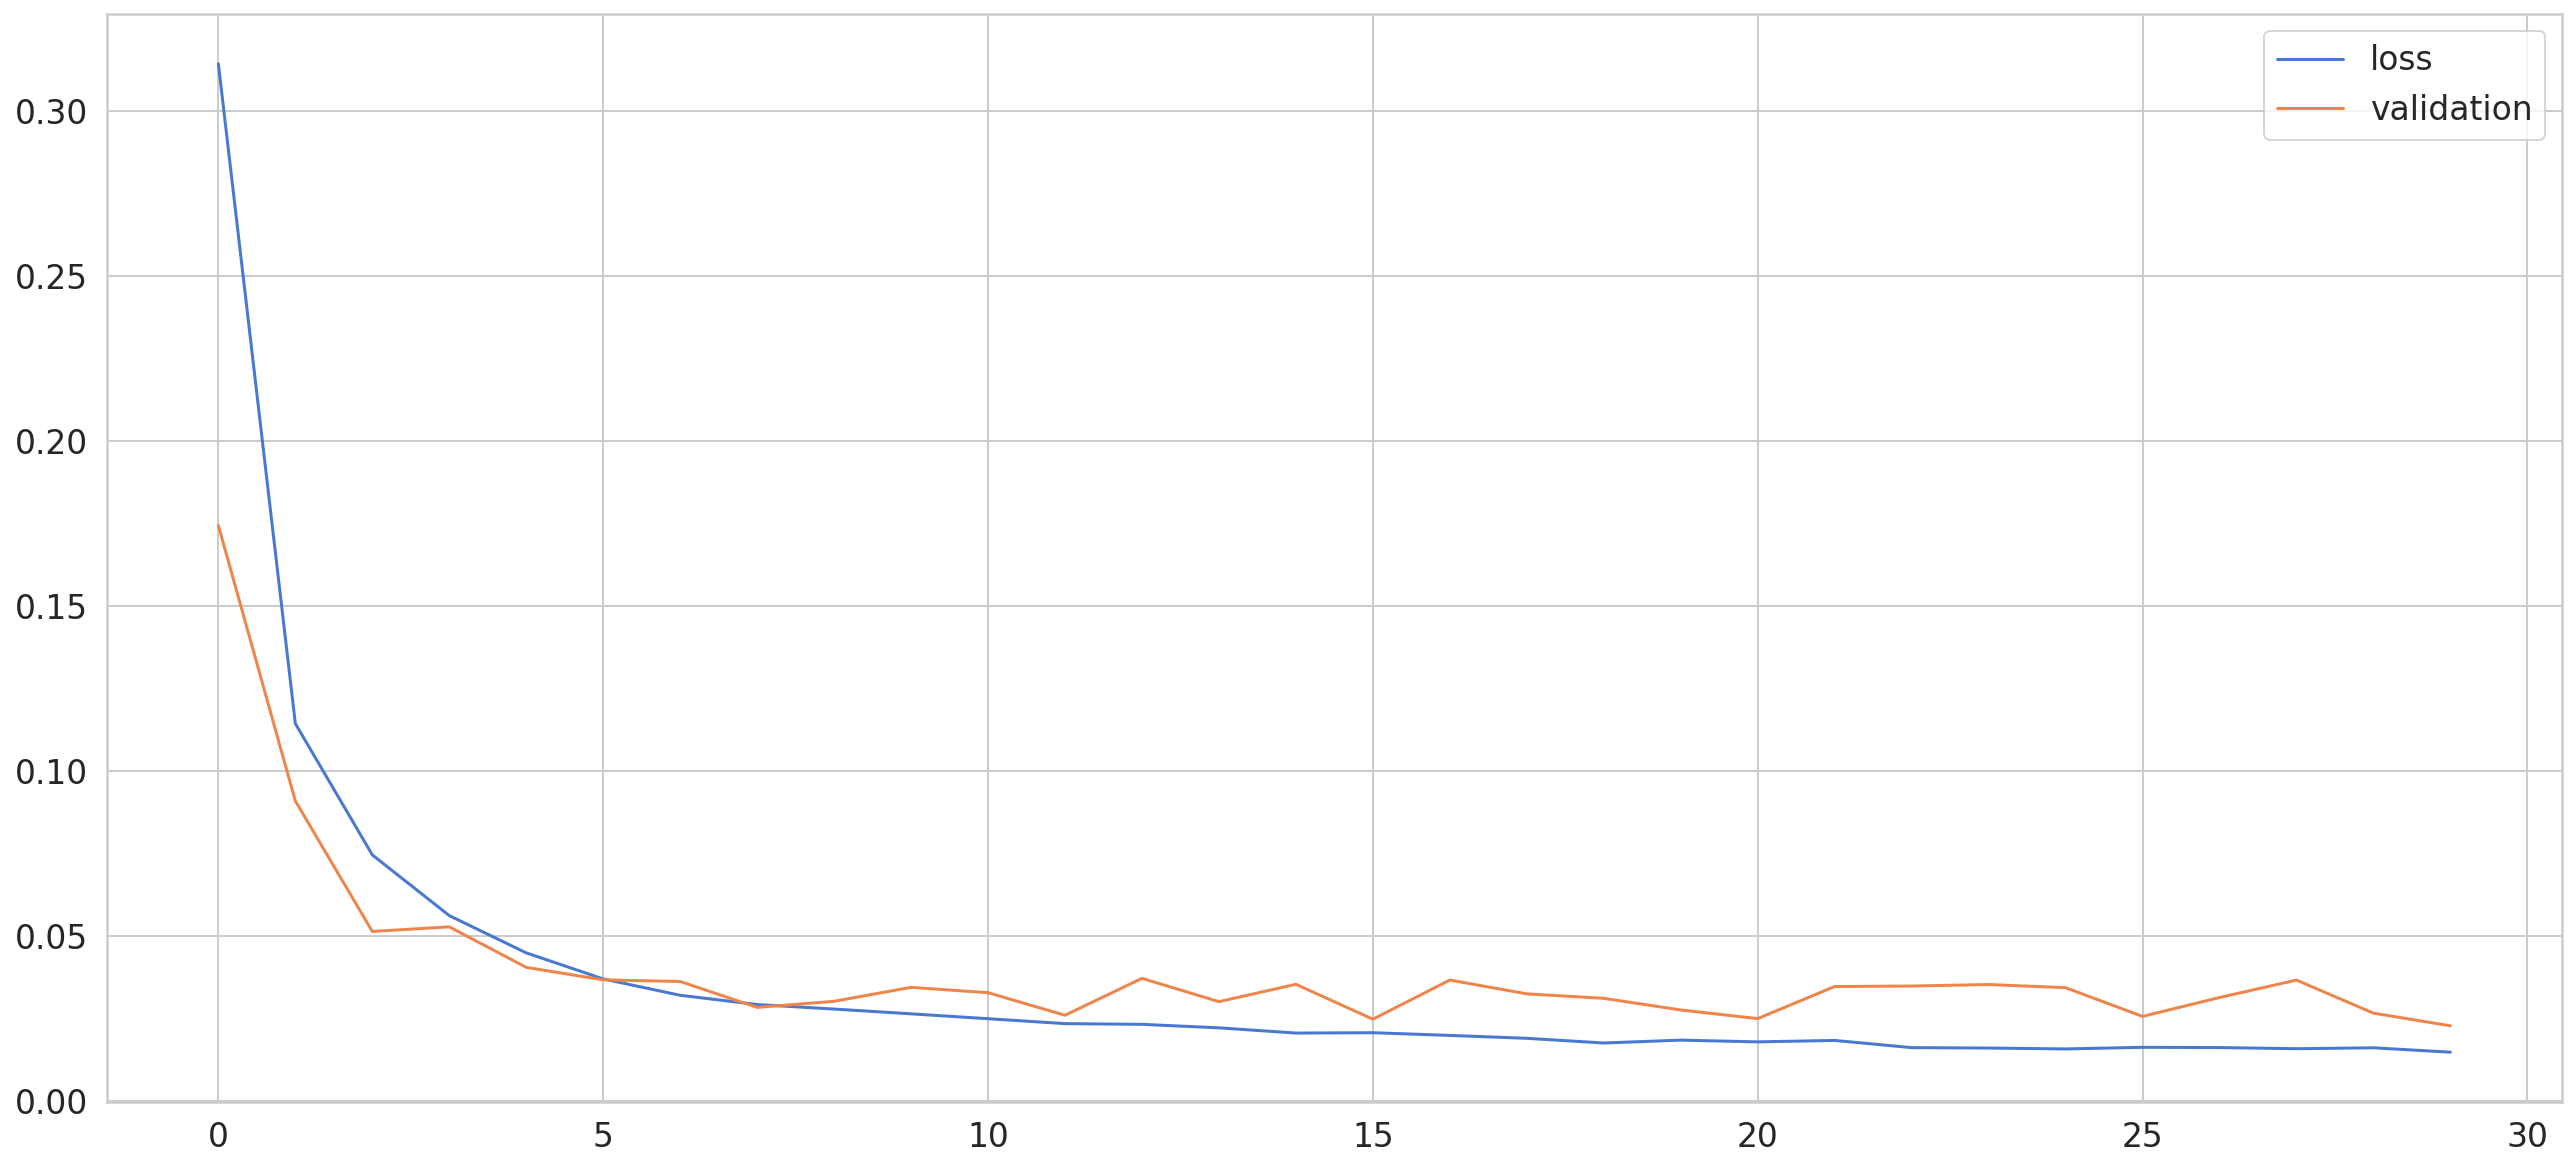

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

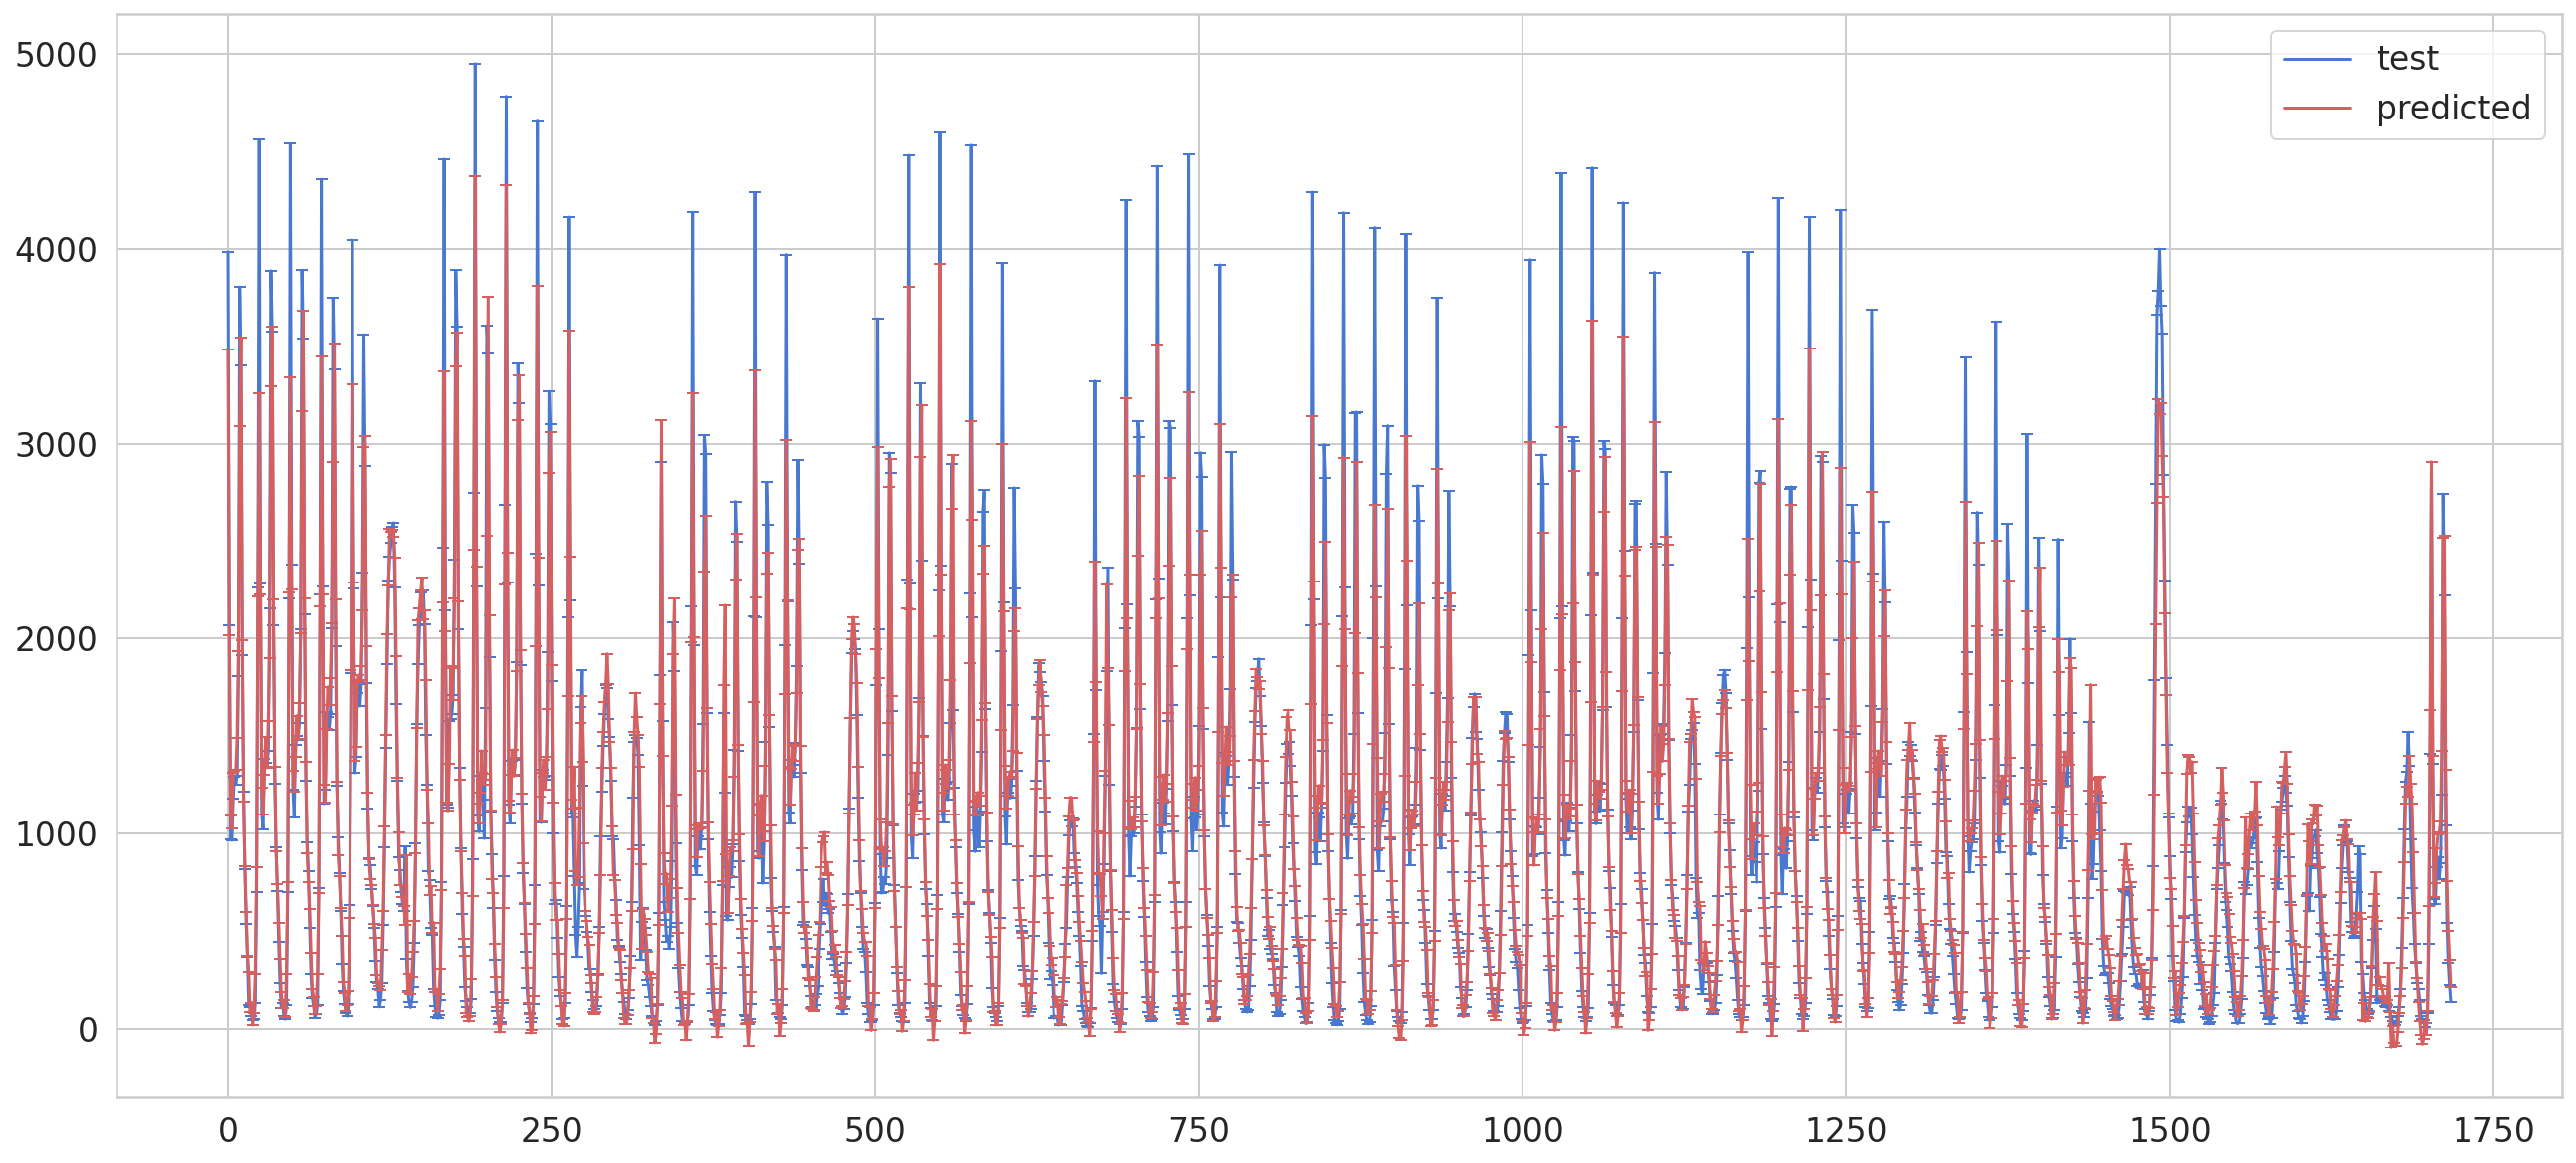

In [39]:
plt.plot(y_test_inv.flatten(), marker='_', label='test')
plt.plot(y_pred_inv.flatten(), 'r',marker='_', label='predicted')
plt.legend()